## Deep Neural Network model with top n feature selection
*Summary:* In this notebook, we use a DNN model to predict `attack_cat` labels.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [2]:
labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing
The preprocessing includes the reduction of categorical features, one hot encoding the selected categorical features, and clamping the features that have a maximum of 10 times the median to the 95th quantile. We start with exploring the value counts of the categorical features.

In [16]:
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns
x_df[cat_cols].describe()

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


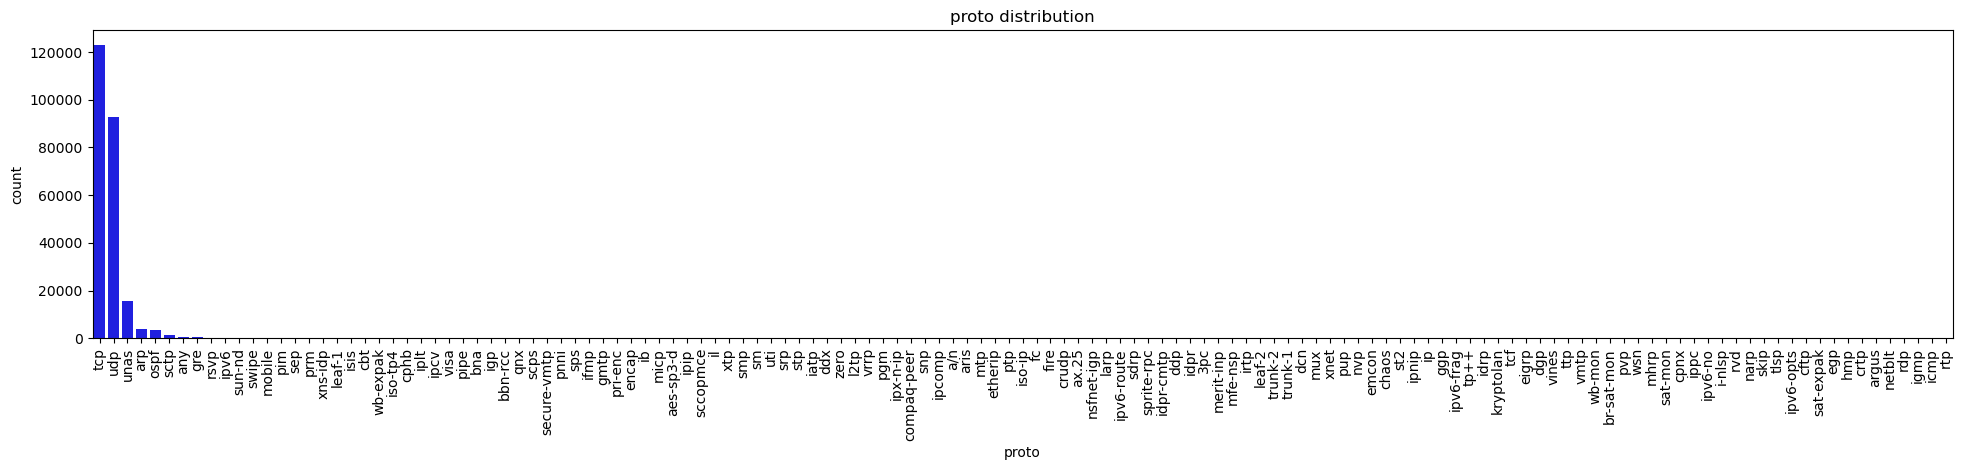

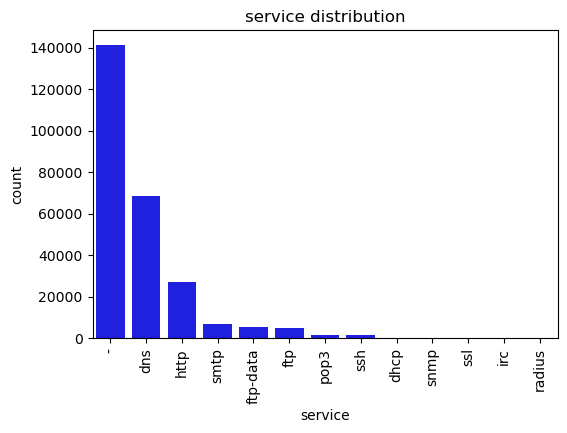

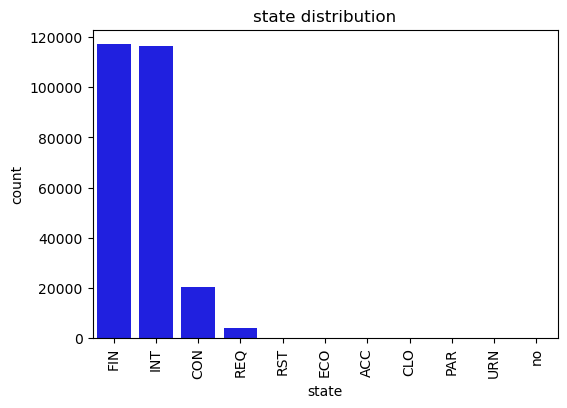

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_col(col_name: str, size: tuple):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=col_name, color='blue', data=df, order = df[col_name].value_counts().index)
    ax.set_title(f"{col_name} distribution")
    plt.xticks(rotation=90)
    plt.show()

plot_cat_col('proto', (24, 4))
plot_cat_col('service', (6, 4))
plot_cat_col('state', (6, 4))

From the above plots, we can see that the categorical distribution is very skewed. The `proto` feature will cause the "curse of dimensionality" as most of the values that this feature can take are so rare that it will make training very difficult. 
Furthermore, we can reduce the dimensionality by keeping the top `n` counts and grouping the rest together as a single value.
For the categorical variables, we chose the following values for `n`:
- `proto`: 5
- `service`: 6
- `state`: 4

In [12]:
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns

n_map = {
    'proto': 5,
    'service': 6,
    'state': 4,
}
for feature in cat_cols:
    top_n = x_df[feature].value_counts().index[:n_map[feature]]
    print(top_n)

Index(['tcp', 'udp', 'unas', 'arp', 'ospf'], dtype='object')
Index(['-', 'dns', 'http', 'smtp', 'ftp-data', 'ftp'], dtype='object')
Index(['FIN', 'INT', 'CON', 'REQ'], dtype='object')


In [3]:
from preprocessing import apply_clamping, reduce_top_n

n_map = {
    'proto': 5,
    'service': 6,
    'state': 4,
}

x_df = reduce_top_n(x_df, n_map)

num_cols = x_df.select_dtypes(include=[np.number]).columns
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns

x_df = pd.concat([x_df[num_cols], pd.get_dummies(x_df[cat_cols])], axis=1)

x_df = apply_clamping(x_df)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)

sc = StandardScaler()
x_df.iloc[:, :n_num_cols] = sc.fit_transform(x_df.iloc[:, :n_num_cols])

pca = PCA(n_components=0.95)
x = pca.fit_transform(x_df)
x_df = pd.DataFrame(x)
x_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.742701,0.776136,0.001981,0.866155,0.060093,-1.037282,-0.242787,0.060296,0.641733,0.162136,-0.289315,0.176494,-0.212142,-0.320688,-0.972845,0.278638,0.545580,0.167573
1,-1.582456,1.619751,1.070115,1.261846,-1.356728,-2.430056,-0.771475,-0.554466,1.572970,0.120536,0.259501,0.163122,0.058936,-0.849138,-1.348846,0.828410,0.150789,0.087548
2,-1.097445,1.584410,1.079659,1.051522,-1.178872,-2.261290,-0.716609,-0.213132,1.047270,0.067589,-0.028604,0.246161,0.046147,-0.568152,-1.250282,0.413374,0.251403,0.532932
3,-0.996493,1.429844,0.858025,1.032245,-0.934096,-1.998228,-0.624494,-0.187618,0.847906,0.093152,0.058660,0.101534,-0.001629,-0.416772,-1.182587,0.327645,0.293964,0.528505
4,-1.706462,1.569659,1.050989,1.231764,-1.359580,-2.389535,-0.713628,-0.643023,1.649860,0.109035,0.383521,0.138333,0.055391,-0.883351,-1.310567,0.888651,0.053870,-0.000939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,-0.800067,-0.092007,-0.400079,0.314675,0.853686,0.616610,-0.191863,-0.888797,-0.297161,0.243009,1.651919,-1.050076,0.190541,0.153642,1.001404,0.735693,-0.924345,0.521485
257669,1.150684,-1.298255,-0.152399,0.065624,0.950475,-0.474725,-2.241153,-0.030793,0.726465,0.350966,-0.013539,0.368280,0.115395,0.325856,-0.158347,-0.726127,-0.025037,-0.665825
257670,-0.252668,0.218435,-0.418848,-0.208180,1.104486,0.241496,0.074843,0.559696,0.536354,0.052235,-1.268044,1.106501,-0.270993,-0.566971,0.047063,0.271261,0.288057,0.121864
257671,-0.859619,-0.070321,-0.193877,-0.284132,0.822632,0.587945,0.068730,-0.792271,-0.053975,0.051674,1.459292,-0.579505,0.163932,-0.026002,1.140985,0.610696,-1.298782,0.534474


As can be seen below, the attack categories are imbalanced

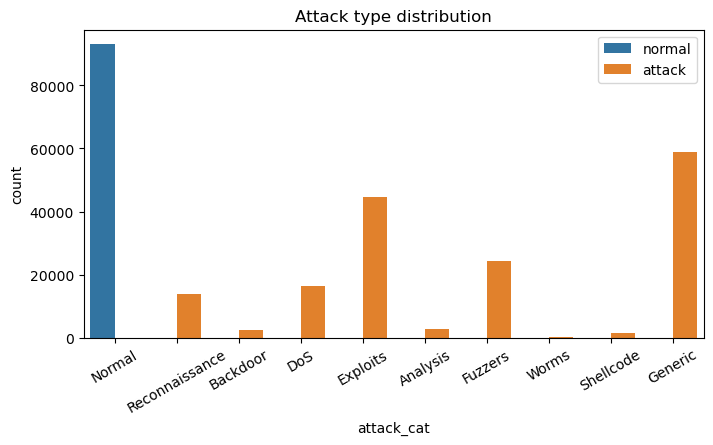

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='attack_cat', hue='label', data=df)
ax.legend(loc="upper right", labels=('normal', 'attack'))
ax.set_title("Attack type distribution")
plt.xticks(rotation=30)
plt.show()

In [9]:
labels.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

We use the SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset 

In [10]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_df, labels)
(X_res.shape, y_res.shape)

((930000, 18), (930000,))

In [98]:
# X_res = X_res.iloc[:300000, :]
# y_res = y_res.iloc[:300000]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.33, random_state=42)

X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

((613100, 18), (306900, 18), (10000, 18), (613100,), (306900,), (10000,))

In [12]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(128, activation='relu', use_bias=True),
        layers.Dense(64, activation='relu', use_bias=True),
        layers.Dense(32, activation='relu', use_bias=True),
        layers.Dense(10, activation='softmax', use_bias=True)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 139,018
Trainable params: 139,018
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')

In [15]:
import os

checkpoint_path = "../models/model_dnn_mc_top10.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [16]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, 
                    batch_size=100, 
                    shuffle=True, 
                    verbose=2,
                    callbacks=[cp_callback])

Epoch 1/100

Epoch 1: saving model to ../models\model_dnn_mc_top10.ckpt
614/614 - 8s - loss: 0.9431 - accuracy: 0.6389 - val_loss: 0.8315 - val_accuracy: 0.6649 - 8s/epoch - 13ms/step
Epoch 2/100

Epoch 2: saving model to ../models\model_dnn_mc_top10.ckpt
614/614 - 7s - loss: 0.7906 - accuracy: 0.6830 - val_loss: 0.7700 - val_accuracy: 0.6887 - 7s/epoch - 11ms/step
Epoch 3/100

Epoch 3: saving model to ../models\model_dnn_mc_top10.ckpt
614/614 - 7s - loss: 0.7561 - accuracy: 0.6938 - val_loss: 0.7355 - val_accuracy: 0.7008 - 7s/epoch - 12ms/step
Epoch 4/100

Epoch 4: saving model to ../models\model_dnn_mc_top10.ckpt
614/614 - 12s - loss: 0.7330 - accuracy: 0.7010 - val_loss: 0.7370 - val_accuracy: 0.6992 - 12s/epoch - 19ms/step
Epoch 5/100

Epoch 5: saving model to ../models\model_dnn_mc_top10.ckpt
614/614 - 7s - loss: 0.7186 - accuracy: 0.7058 - val_loss: 0.7235 - val_accuracy: 0.6964 - 7s/epoch - 12ms/step
Epoch 6/100

Epoch 6: saving model to ../models\model_dnn_mc_top10.ckpt
614/61

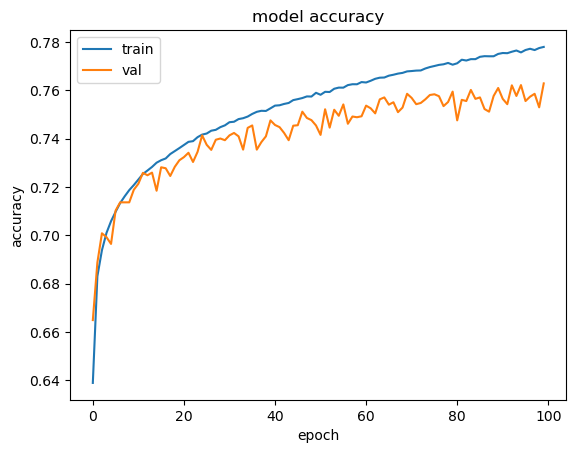

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

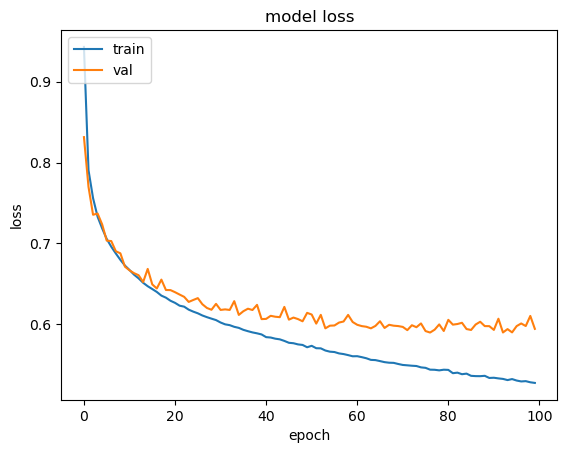

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
y_pred = model.predict(X_test)

9591/9591 [==============================] - 10s 1ms/step


In [21]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob = self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, sorted(list(labels.unique())))

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

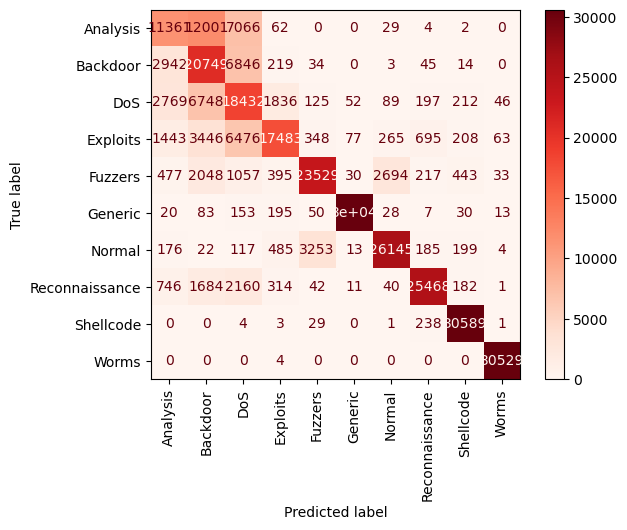

In [23]:
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [24]:
from sklearn.metrics import accuracy_score

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

accuracy_score(ys, ys_pred)

0.7645845552297165